In [1]:
# ! pip install xarray cfgrib eccodes --quiet

In [2]:
# ! uv add kagglehub

In [3]:
import duckdb
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMapWithTime

from sklearn.neighbors import BallTree

pd.set_option('display.max_columns', None)

In [4]:
con = duckdb.connect('/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/data/iNaturalist.duckdb')
print("connected!")

connected!


In [5]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

# print("Path to dataset files:", path)

In [6]:
# Load the kc_house dataset
path = "../data/kc_house_data.csv"
kc_house = pd.read_csv(path)
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
kc_house["date"] = pd.to_datetime(kc_house["date"], format="%Y%m%dT%H%M%S")
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
kc_house["date"].apply(lambda x: x.year).value_counts()

date
2014    14633
2015     6980
Name: count, dtype: int64

In [9]:
kc_house["date"] = pd.to_datetime(kc_house["date"])

year_replacements = {2013: 2020, 2014: 2021, 2015: 2022, 2016: 2023}

kc_house['date'] = kc_house['date'].apply(lambda x: x.replace(year=year_replacements.get(x.year, x.year)))
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2021-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2021-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2022-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2021-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2022-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
con.execute("""
    CREATE TABLE IF NOT EXISTS kc_house AS
        SELECT * 
        FROM kc_house;
""")
print(f"kc_house created")

kc_house created


In [11]:
# List all tables
tables = con.execute("SHOW TABLES").fetchdf()
print(tables)

                       name
0                ERA5_Daily
1                 era5_grid
2               iNaturalist
3  iNaturalist_grid_mapping
4                  kc_house
5     kc_house_grid_mapping


In [12]:
#min_date = "2020-01-01"
#max_date = "2025-12-31"

query = f"""
-- This can be grouped further
SELECT *
FROM ERA5_grid;
"""
df_ERA5_grid = con.execute(query).df()
# Remove a few of the first days that don't have 7-days histories (I didn't get 2019 data)
df_ERA5_grid

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1
2,-90.0,0.50,2
3,-90.0,0.75,3
4,-90.0,1.00,4
...,...,...,...
1038235,90.0,358.75,1038235
1038236,90.0,359.00,1038236
1038237,90.0,359.25,1038237
1038238,90.0,359.50,1038238


In [13]:
query = """
WITH kc_house_coordinates AS (
    SELECT DISTINCT id, lat, long
    FROM kc_house
)
SELECT *
FROM kc_house_coordinates
"""
kc_house_coordinates = con.execute(query).df()
kc_house_coordinates

,id,lat,long
0,7203220400,47.6848,-122.016
1,4178300310,47.6194,-122.151
2,3717000160,47.3378,-122.257
3,1802000060,47.6303,-122.215
4,1523059105,47.4811,-122.149
...,...,...,...
21431,7430500110,47.6249,-122.090
21432,2855000110,47.3906,-122.304
21433,7853420110,47.5184,-121.886
21434,6632300207,47.7337,-122.309


In [14]:
query = """
SELECT latitude, longitude, grid_id
FROM era5_grid
ORDER BY latitude, longitude
"""
era5_grid = con.execute(query).df()
era5_grid

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1
2,-90.0,0.50,2
3,-90.0,0.75,3
4,-90.0,1.00,4
...,...,...,...
1038235,90.0,358.75,1038235
1038236,90.0,359.00,1038236
1038237,90.0,359.25,1038237
1038238,90.0,359.50,1038238


In [15]:
# Convert degrees to radians
kc_house_coords = np.radians(kc_house_coordinates[['lat', 'long']])
era5_coords = np.radians(era5_grid[['latitude', 'longitude']])

# Build BallTree using Haversine metric (expects radians)
print("Building BallTree")
tree = BallTree(era5_coords, metric='haversine')

# Query nearest neighbor (returns distance in radians)
print("Query nearest neighbor in kc_house_coords")
distances, indices = tree.query(kc_house_coords, k=1)

# Get nearest grid_id for each kc_house point
print("Get nearest grid_id")
nearest_grid_ids = era5_grid.iloc[indices.flatten()]['grid_id'].values

# Add nearest_grid_id column
kc_house_coordinates['nearest_grid_id'] = nearest_grid_ids

# Convert Haversine distance to km
earth_radius_km = 6371
kc_house_coordinates['distance_km'] = distances.flatten() * earth_radius_km
kc_house_coordinates.head()

Building BallTree
Query nearest neighbor in kc_house_coords
Get nearest grid_id


,id,lat,long,nearest_grid_id,distance_km
0,7203220400,47.6848,-122.016,794392,7.348055
1,4178300310,47.6194,-122.151,792951,15.213633
2,3717000160,47.3378,-122.257,791511,9.777177
3,1802000060,47.6303,-122.215,794391,13.565397
4,1523059105,47.4811,-122.149,792951,7.874334


In [16]:
# number of unique grid ids matched
kc_house_coordinates["nearest_grid_id"].nunique()

15

In [17]:
# Create the grid table in DuckDB
con.execute("CREATE TABLE IF NOT EXISTS kc_house_grid_mapping AS SELECT * FROM kc_house_coordinates")
print("Table 'kc_house_grid_mapping' created successfully!")

Table 'kc_house_grid_mapping' created successfully!


In [18]:
query = """
SELECT *
FROM kc_house
"""
df = con.execute(query).df()
df["date"].min(), df["date"].max()

(Timestamp('2021-05-02 00:00:00'), Timestamp('2022-05-27 00:00:00'))

In [19]:
min_date = "2021-01-01"
max_date = "2022-12-31"

query = f"""
WITH filtered_kc_house AS (
    SELECT
        id,
        date AS dateOcurrence,  -- keep only the date part
        lat,
        long,
        price
    FROM kc_house
    WHERE
        lat IS NOT NULL
        AND long IS NOT NULL
        AND date IS NOT NULL 
        AND dateOcurrence IS NOT NULL
),

mapped_kc_house AS (
    SELECT
        CAST(filtered_kc_house.dateOcurrence AS DATE) AS dateOcurrence,
        filtered_kc_house.lat,
        filtered_kc_house.long,
        filtered_kc_house.price,
        kc_house_grid_mapping.nearest_grid_id,
    FROM filtered_kc_house AS filtered_kc_house
    JOIN kc_house_grid_mapping AS kc_house_grid_mapping
    USING (id)
),

mapped_ERA5 AS (
    SELECT
        CAST(ERA5_Daily.valid_time AS DATE) AS valid_time,
        ERA5_Daily.latitude,
        ERA5_Daily.longitude,
        ERA5_grid.grid_id,
        -- Build the array of 7 historical + current values (ordered by date)
        LIST(u10) OVER w AS u10_hist,
        LIST(v10) OVER w AS v10_hist,
        LIST(d2m) OVER w AS d2m_hist,
        LIST(t2m) OVER w AS t2m_hist,
        LIST(msl) OVER w AS msl_hist,
        LIST(mwd) OVER w AS mwd_hist,
        LIST(mwp) OVER w AS mwp_hist,
        LIST(sst) OVER w AS sst_hist,
        LIST(swh) OVER w AS swh_hist,
        LIST(sp)  OVER w AS sp_hist,
        LIST(tp)  OVER w AS tp_hist

    FROM ERA5_Daily
    JOIN ERA5_grid 
      ON ERA5_Daily.latitude = ERA5_grid.latitude
     AND ERA5_Daily.longitude = ERA5_grid.longitude
    WHERE
        valid_time BETWEEN '{min_date}' AND '{max_date}'
        AND ERA5_grid.grid_id IN (
            SELECT DISTINCT nearest_grid_id
            FROM mapped_kc_house
        )

    WINDOW w AS (
        PARTITION BY grid_id
        ORDER BY valid_time
        -- This gets the last 90 days before valid_time and the current valid_time
        ROWS BETWEEN 90 PRECEDING AND CURRENT ROW
    )
),

joined_kc_house_ERA5 AS (
    SELECT
        mapped_kc_house.dateOcurrence,
        mapped_kc_house.lat,
        mapped_kc_house.long,
        mapped_kc_house.price,
        mapped_kc_house.nearest_grid_id,
        mapped_ERA5.latitude AS nearest_grid_id_latitude,
        mapped_ERA5.longitude AS nearest_grid_id_longitude,
        mapped_ERA5.u10_hist,
        mapped_ERA5.v10_hist,
        mapped_ERA5.d2m_hist,
        mapped_ERA5.t2m_hist,
        mapped_ERA5.msl_hist,
        -- mapped_ERA5.mwd_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.mwp_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.sst_hist, -- these are sea variables, so they appear as NaN on the land
        -- mapped_ERA5.swh_hist, -- these are sea variables, so they appear as NaN on the land
        mapped_ERA5.sp_hist,
        mapped_ERA5.tp_hist
    FROM mapped_kc_house AS mapped_kc_house
    JOIN mapped_ERA5 AS mapped_ERA5
      ON mapped_kc_house.nearest_grid_id = mapped_ERA5.grid_id
      AND mapped_kc_house.dateOcurrence = mapped_ERA5.valid_time
)

-- This can be grouped further
SELECT *
FROM joined_kc_house_ERA5
ORDER BY dateOcurrence, lat, long;
"""
#result = con.sql(query).fetchdf()

df = con.execute(query).df()
# df = df[df["u10_hist"].apply(len) == 91]
df


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,dateOcurrence,lat,long,price,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist
0,2021-05-02,47.2617,-122.190,400000.0,791511,47.25,237.75,"[-1.120099425315857, 1.1628074645996094, -0.39...","[0.814559280872345, 2.929656982421875, 0.61214...","[279.2066345214844, 278.0447998046875, 275.597...","[280.4072265625, 279.519287109375, 278.1062316...","[100955.7578125, 100848.65625, 101364.7265625,...","[98063.3671875, 97927.5, 98407.3203125, 99832....","[0.0007340709562413394, 0.0008300145273096859,..."
1,2021-05-02,47.2703,-122.069,491500.0,791512,47.25,238.00,"[-1.637189269065857, 0.561163604259491, -0.509...","[0.796248733997345, 1.8718770742416382, 0.3663...","[278.89404296875, 277.5045166015625, 274.08963...","[279.8191833496094, 278.6272888183594, 276.506...","[100974.1015625, 100878.2578125, 101386.507812...","[96167.6171875, 96022.75, 96472.53125, 97880.1...","[0.0005600650911219418, 0.0009248058195225894,..."
2,2021-05-02,47.3256,-122.378,604000.0,791510,47.25,237.50,"[-0.7761866450309753, 1.5236066579818726, -0.3...","[0.683699905872345, 3.3844501972198486, 0.7993...","[280.1409606933594, 279.0350341796875, 276.899...","[281.2571716308594, 280.60693359375, 279.54379...","[100945.5703125, 100841.5703125, 101356.164062...","[100342.15625, 100234.0859375, 100741.6875, 10...","[0.0007982452516444027, 0.0007687012548558414,..."
3,2021-05-02,47.3279,-122.191,367500.0,791511,47.25,237.75,"[-1.120099425315857, 1.1628074645996094, -0.39...","[0.814559280872345, 2.929656982421875, 0.61214...","[279.2066345214844, 278.0447998046875, 275.597...","[280.4072265625, 279.519287109375, 278.1062316...","[100955.7578125, 100848.65625, 101364.7265625,...","[98063.3671875, 97927.5, 98407.3203125, 99832....","[0.0007340709562413394, 0.0008300145273096859,..."
4,2021-05-02,47.3358,-122.055,300000.0,791512,47.25,238.00,"[-1.637189269065857, 0.561163604259491, -0.509...","[0.796248733997345, 1.8718770742416382, 0.3663...","[278.89404296875, 277.5045166015625, 274.08963...","[279.8191833496094, 278.6272888183594, 276.506...","[100974.1015625, 100878.2578125, 101386.507812...","[96167.6171875, 96022.75, 96472.53125, 97880.1...","[0.0005600650911219418, 0.0009248058195225894,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2022-05-14,47.6854,-122.331,855000.0,794391,47.75,237.75,"[-1.3329263925552368, -0.36495843529701233, 0....","[0.016381582245230675, 3.692528486251831, 1.02...","[274.2567138671875, 278.0333251953125, 278.701...","[278.8783264160156, 281.67877197265625, 280.35...","[102307.0859375, 101357.34375, 102013.75, 1023...","[101638.1875, 100685.4453125, 101329.7265625, ...","[0.0, 0.00015888611960690469, 1.43448514791089..."
21609,2022-05-14,47.7052,-122.343,359000.0,794391,47.75,237.75,"[-1.3329263925552368, -0.36495843529701233, 0....","[0.016381582245230675, 3.692528486251831, 1.02...","[274.2567138671875, 278.0333251953125, 278.701...","[278.8783264160156, 281.67877197265625, 280.35...","[102307.0859375, 101357.34375, 102013.75, 1023...","[101638.1875, 100685.4453125, 101329.7265625, ...","[0.0, 0.00015888611960690469, 1.43448514791089..."
21610,2022-05-15,47.5951,-122.144,450000.0,792951,47.50,237.75,"[0.9188957214355469, 0.5322920680046082, 0.294...","[2.8826732635498047, 1.311057448387146, 1.5062...","[278.2192077636719, 278.871337890625, 277.7494...","[282.07476806640625, 280.4344177246094, 280.80...","[101400.8125, 102026.1484375, 102398.3515625, ...","[100482.9453125, 101092.5234375, 101461.78125,...","[0.00017142295837402344, 1.3728936210100073e-0..."
21611,2022-05-24,47.6914,-122.308,445500.0,794391,47.75,237.75,"[-0.4097270965576172, -0.7139752507209778, -0....","[-0.8106403350830078, 0.30012640357017517, 0.7...","[264.5570068359375, 267.1229248046875, 269.254...","[272.9244079589844, 274.1316223144531, 274.847...","[102996.4921875, 102896.0625, 103126.7109375, ...","[102286.6328125, 102190.7421875, 102426.648437...","[0.0, 3.43

In [20]:
df["u10_hist"].apply(len).value_counts()

u10_hist
91    21613
Name: count, dtype: int64

In [21]:
df["nearest_grid_id"].value_counts()

nearest_grid_id
792951    6427
794391    5967
792952    2212
791511    1926
794392    1650
791512    1073
792950     930
794390     802
792953     424
791510     170
794393      13
794395      11
794394       5
791513       2
792954       1
Name: count, dtype: int64

# Data

## KC-House joined with ERA5
The idea is that for a given observation with (latitude, longitude, time) we can join this with the ERA5 dataset to get relevant climate features for that specific place and time. 


These are the variables in the ERA5 dataset

```python
era5_variable_names = {
    "u10": "10m u-component of wind",
    "v10": "10m v-component of wind",
    "d2m": "2m dewpoint temperature",
    "t2m": "2m temperature",
    "msl": "Mean sea level pressure",
    "mwd": "Mean wave direction",
    "mwp": "Mean wave period",
    "sst": "Sea surface temperature",
    "swh": "Significant height of combined wind waves and swell",
    "sp": "Surface pressure",
    "tp": "Total precipitation"
}
```

### Daily Aggregation



#### Aggregating by `dateOcurrence` and `nearest_grid_id`

We can group the data by `dateOcurrence` and `nearest_grid_id` to keep a daily resolution while combining all observations within the same grid cell into a single aggregated record.

In [22]:
# cols = [
#     "dateOcurrence",
#     "nearest_grid_id",
#     "nearest_grid_id_latitude",
#     "nearest_grid_id_longitude",
#     "lat",
#     "long",
#     "price",
#     "u10_hist",
#     "v10_hist",
#     "d2m_hist",
#     "t2m_hist",
#     "msl_hist",
#     "sp_hist",
#     "tp_hist",
# ]

# # Sort so that "most recent" means "last" in each group
# df = df.sort_values("dateOcurrence")

# agg_df = (
#     df.groupby(["dateOcurrence", "nearest_grid_id"], as_index=False)
#       .agg({
#           "price": "mean",
#           "lat": list,
#           "long": list,
#           "nearest_grid_id_latitude": "last",
#           "nearest_grid_id_longitude": "last",
#           "u10_hist": "last",
#           "v10_hist": "last",
#           "d2m_hist": "last",
#           "t2m_hist": "last",
#           "msl_hist": "last",
#           "sp_hist": "last",
#           "tp_hist": "last",
#       })
# )
# agg_df = agg_df[cols]
# agg_df


#### Aggregating by `year_week` and `nearest_grid_id`

We can group the data by `year_week` and `nearest_grid_id` to produce weekly aggregated records, combining all observations within the same grid cell for each week.

In [23]:
# cols = [
#     "year_week",
#     "dateOcurrence",
#     "nearest_grid_id",
#     "nearest_grid_id_latitude",
#     "nearest_grid_id_longitude",
#     "lat",
#     "long",
#     "price",
#     "u10_hist",
#     "v10_hist",
#     "d2m_hist",
#     "t2m_hist",
#     "msl_hist",
#     "sp_hist",
#     "tp_hist",
# ]

# df["dateOcurrence"] = pd.to_datetime(df["dateOcurrence"])

# # Create a week-of-year column
# iso = df["dateOcurrence"].dt.isocalendar()
# df["year_week"] = iso["year"].astype(str) + "-" + iso["week"].astype(str).str.zfill(2)


# # Sort so that "most recent" means "last" in each group
# df = df.sort_values("dateOcurrence")

# agg_df = (
#     df
#     .groupby(["year_week", "nearest_grid_id"], as_index=False)
#     .agg({
#           "price": "mean",
#           "dateOcurrence": list,
#           "lat": list,
#           "long": list,
#           "nearest_grid_id_latitude": "last",
#           "nearest_grid_id_longitude": "last",
#           "u10_hist": "last",
#           "v10_hist": "last",
#           "d2m_hist": "last",
#           "t2m_hist": "last",
#           "msl_hist": "last",
#           "sp_hist": "last",
#           "tp_hist": "last",
#       }
#     )
# )
# agg_df = agg_df[cols]
# agg_df

## SatCLIP embeddings

Let's use the aggregated dataframe by `year_week` and `nearest_grid_id`.

Provide coordinates in standard decimal degrees:
- Longitude: -180° to 180° or 0° to 360°, it transforms to radians internally
- Latitude: -90° to 90°
- SatCLIP expects (longitude, latitude)

See [B01 - Use SatCLIP embeddings to predict air temperatures](https://github.com/microsoft/satclip/blob/main/notebooks/B01_Example_Air_Temperature_Prediction.ipynb)

In [24]:
import sys
import os
satclip_path = "/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/Repositories/satclip/"

sys.path.append(satclip_path)
sys.path.insert(0, os.path.join(satclip_path, "satclip"))

In [25]:
import torch
from tqdm import tqdm

from huggingface_hub import hf_hub_download
from satclip.model import SatCLIP
from satclip.location_encoder import LocationEncoder
from load import get_satclip

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cuda


In [26]:
locations = torch.randn(32, 2)  # Represents a batch of 32 locations (lon/lat)

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
    device=device,
)  # Only loads location encoder by default
model.eval()

using pretrained moco vit16


LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)

In [27]:
coordinates = [
    [-10.0, 20.0],
    [350.0, 20.0]
]
coordinates = torch.tensor(coordinates, dtype=torch.float32)

# SatCLIP expects (longitude, latitude)
with torch.no_grad():
    embeddings = model(coordinates.double().to(device)).detach().cpu()

print(embeddings.shape)
embeddings[0][0:5], embeddings[1][0:5]

torch.Size([2, 256])


(tensor([-0.9325, -3.1614, -1.7830,  1.6011, -4.0437], dtype=torch.float64),
 tensor([-0.9325, -3.1614, -1.7830,  1.6011, -4.0437], dtype=torch.float64))

In [28]:
# Prepare data (lon, lat)
coords = df[["lat", "long"]].values
coords = torch.tensor(coords, dtype=torch.float32)

batch_size = 512
emb_list = []

with torch.no_grad():
    for i in tqdm(range(0, len(coords), batch_size)):
        batch = coords[i : i + batch_size]
        batch = batch.double().to(device)

        emb = model(batch).detach().cpu()
        emb_list.append(emb)

# Concatenate all batches
all_embeddings = torch.cat(emb_list, dim=0).numpy()
print(f"{all_embeddings.shape}")

# Add as new dataframe column
df["satclip_embeddings"] = list(all_embeddings)

100%|██████████| 43/43 [00:19<00:00,  2.18it/s]

(21613, 256)


In [29]:
df.head(2)

,dateOcurrence,lat,long,price,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist,satclip_embeddings
0,2021-05-02,47.2617,-122.190,400000.0,791511,47.25,237.75,"[-1.120099425315857, 1.1628074645996094, -0.39...","[0.814559280872345, 2.929656982421875, 0.61214...","[279.2066345214844, 278.0447998046875, 275.597...","[280.4072265625, 279.519287109375, 278.1062316...","[100955.7578125, 100848.65625, 101364.7265625,...","[98063.3671875, 97927.5, 98407.3203125, 99832....","[0.0007340709562413394, 0.0008300145273096859,...","[3.1777146132745644, 5.105216703484368, 2.0743..."
1,2021-05-02,47.2703,-122.069,491500.0,791512,47.25,238.00,"[-1.637189269065857, 0.561163604259491, -0.509...","[0.796248733997345, 1.8718770742416382, 0.3663...","[278.89404296875, 277.5045166015625, 274.08963...","[279.8191833496094, 278.6272888183594, 276.506...","[100974.1015625, 100878.2578125, 101386.507812...","[96167.6171875, 96022.75, 96472.53125, 97880.1...","[0.0005600650911219418, 0.0009248058195225894,...","[3.3383483010977413, 5.317380222081496, 2.0679..."


In [30]:
columns = [
    "dateOcurrence",
    "lat",
    "long",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "price"
]

df[columns]

,dateOcurrence,lat,long,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,price
0,2021-05-02,47.2617,-122.190,791511,47.25,237.75,"[3.1777146132745644, 5.105216703484368, 2.0743...",400000.0
1,2021-05-02,47.2703,-122.069,791512,47.25,238.00,"[3.3383483010977413, 5.317380222081496, 2.0679...",491500.0
2,2021-05-02,47.3256,-122.378,791510,47.25,237.50,"[2.937354105435716, 4.7621614477133924, 2.0622...",604000.0
3,2021-05-02,47.3279,-122.191,791511,47.25,237.75,"[3.1974187674925187, 5.130109237894445, 2.0690...",367500.0
4,2021-05-02,47.3358,-122.055,791512,47.25,238.00,"[3.3777874465739064, 5.364646921611664, 2.0617...",300000.0
...,...,...,...,...,...,...,...,...
21608,2022-05-14,47.6854,-122.331,794391,47.75,237.75,"[3.1064519744845467, 5.005847278424744, 2.0321...",855000.0
21609,2022-05-14,47.7052,-122.343,794391,47.75,237.75,"[3.0943093602050205, 4.989798758414547, 2.0292...",359000.0
21610,2022-05-15,47.5951,-122.144,792951,47.50,237.75,"[3.3419871796963614, 5.314478445324062, 2.0447...",450000.0
21611,2022-05-24,47.6914,-122.308,794391,47.75,237.75,"[3.1410239573637777, 5.053456921837703, 2.0333...",445500.0


# TimesFM


f(decimalLatitude, decimalLongitude, dateOcurrence, u10, v10,    d2m, ...) =  countOccurrences \approx population $, where the coordinates will pass through SatCLIP and the climate features (time series) will be encoded with a time encoder to pass as features to a predictor

In [31]:
# # 1) Load a TimesFM checkpoint (univariate)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

In [32]:
# #input_df = agg_df.copy().drop(columns=["countOccurrences"])
# #output_df = agg_df[["countOccurrences"]].copy()

# input_df = agg_df[["countOccurrences"]].copy()
# input_df = input_df.astype("float32").to_numpy()
# input_y = torch.tensor(input_df, dtype=torch.bfloat16, device=model.device)
# past_values = [input_y]

# freq_idx = 0
# freq_tensor = torch.tensor([freq_idx], dtype=torch.long, device=model.device)

In [33]:
# # Build usable 1D numeric series from agg_df object-columns, then pass to TimesFM.
# # (Fixes the "numpy.object_" -> torch.tensor conversion error by converting each row element to numeric
# # arrays and concatenating / stacking into plain float arrays.)

# # 1) Load model (already imported above)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

# # helper: convert an agg_df column of 7-day lists (object dtype) into a single 1D float array
# def col_to_series(col, max_rows=None):
#     vals = agg_df[col].to_numpy()
#     if max_rows is not None:
#         vals = vals[:max_rows]
#     arrs = [np.asarray(v, dtype=float).ravel() for v in vals if v is not None]
#     if len(arrs) == 0:
#         return np.array([], dtype=float)
#     # concatenate rows to get a longer time series (you can change concatenation strategy)
#     return np.concatenate(arrs)

# # create a batch of variable-length series from the ERA5 history columns
# series_cols = ["u10_hist", "v10_hist", "t2m_hist", "msl_hist"]
# series = [col_to_series(c, max_rows=50) for c in series_cols]  # limit rows to avoid extremely long arrays

# # sanity check
# for i, s in enumerate(series):
#     print(f"{series_cols[i]} -> length {s.size}")

# # Convert to torch tensors (use float32 first to avoid object dtype issues), then move to model device and bfloat16
# past_values = []
# for s in series:
#     if s.size == 0:
#         raise ValueError("One of the series is empty; adjust col_to_series/max_rows or inspect agg_df.")
#     t = torch.tensor(s, dtype=torch.float32, device=model.device)
#     past_values.append(t.to(dtype=torch.bfloat16))

# # frequency vector
# freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# # forward pass
# with torch.no_grad():
#     out = model(
#         past_values=past_values,
#         freq=freq,
#         output_hidden_states=True,
#         return_dict=True,
#     )

# # pool valid timesteps for each series
# embeddings = []
# for i, ts in enumerate(past_values):
#     L = ts.shape[0]
#     vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
#     embeddings.append(vec)

# embeddings = torch.stack(embeddings, dim=0)
# embeddings = normalize(embeddings, p=2, dim=1)

# print("embeddings.shape =", embeddings.shape)

In [34]:


# # 1) Load a TimesFM checkpoint (univariate)
# model = TimesFmModelForPrediction.from_pretrained(
#     "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
#     dtype=torch.bfloat16,
#     attn_implementation="sdpa",
#     device_map="auto",
# )

# # 2) Example batch of variable-length time series (replace with your data)
# series = [
#     np.sin(np.linspace(0, 20, 100)),   # length 100
#     np.sin(np.linspace(0, 20, 240)),   # length 240
#     np.sin(np.linspace(0, 20, 512)),   # length 512
#     np.sin(np.linspace(0, 20, 1024)),   # length 1024
# ]

# # Convert to tensors on the model's device
# past_values = [torch.tensor(x, dtype=torch.bfloat16, device=model.device) for x in series]

# # TimesFM uses a small frequency embedding; if you don't know it, you can set zeros.
# # Shape: (batch,)
# freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# # 3) Forward pass requesting hidden states
# with torch.no_grad():
#     out = model(
#         past_values=past_values,
#         freq=freq,
#         output_hidden_states=True,   # <— important
#         return_dict=True,
#     )

# # out.last_hidden_state: (batch, seq_len, hidden_size) after internal padding
# # We'll mean-pool over the *valid* timesteps for each series, then L2-normalize.

# embeddings = []
# for i, ts in enumerate(past_values):
#     L = ts.shape[0]  # original (unpadded) length
#     # slice to valid region, mean-pool over time
#     vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
#     embeddings.append(vec)

# embeddings = torch.stack(embeddings, dim=0)           # (batch, hidden_size)
# embeddings = normalize(embeddings, p=2, dim=1)        # cosine-friendly

# print(embeddings.shape)   # e.g., torch.Size([4, 1280]) for the 500M checkpoint

### Chronos

In [35]:
import argparse
import warnings
from typing import Optional, Literal

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from chronos import ChronosPipeline, ChronosBoltPipeline

In [36]:
def pool_embeddings(
    embeddings: torch.Tensor,
    method: Literal["mean", "max", "last", "first", "cls"] = "mean"
) -> torch.Tensor:
    """
    Pool sequence embeddings into a single vector.
    
    Parameters
    ----------
    embeddings : torch.Tensor
        Embeddings of shape (batch_size, sequence_length, d_model)
    method : str
        Pooling method: 'mean', 'max', 'last', 'first', 'cls'
        - 'mean': Average over sequence dimension
        - 'max': Max pooling over sequence dimension
        - 'last': Take the last token embedding
        - 'first'/'cls': Take the first token embedding
        
    Returns
    -------
    torch.Tensor
        Pooled embeddings of shape (batch_size, d_model)
    """
    if method == "mean":
        return embeddings.mean(dim=1)
    elif method == "max":
        return embeddings.max(dim=1)[0]
    elif method == "last":
        return embeddings[:, -1, :]
    elif method in ["first", "cls"]:
        return embeddings[:, 0, :]
    else:
        raise ValueError(f"Unknown pooling method: {method}")


def add_chronos_embeddings(
    df: pd.DataFrame,
    col_name: str,
    model_name: str = "amazon/chronos-t5-base",
    device: str = "auto",
    batch_size: int = 32,
    pooling_method: Literal["mean", "max", "last", "first", "cls"] = "mean",
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Add Chronos embeddings for the u10_hist column to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing the column
    col_name : str
        Name of the column containing the time series arrays
    model_name : str
        Hugging Face model name or local path to Chronos model
        Options include:
        - "amazon/chronos-t5-tiny" (8M params, fastest)
        - "amazon/chronos-t5-mini" (20M params)
        - "amazon/chronos-t5-small" (46M params, recommended)
        - "amazon/chronos-t5-base" (200M params)
        - "amazon/chronos-t5-large" (710M params, best quality)
        - "amazon/chronos-bolt-tiny" (9M params, very fast)
        - "amazon/chronos-bolt-mini" (21M params)
        - "amazon/chronos-bolt-small" (48M params)
        - "amazon/chronos-bolt-base" (205M params)
    device : str
        Device to run the model on: "auto", "cuda", "cpu", or "cuda:0", etc.
    batch_size : int
        Number of time series to process at once
    pooling_method : str
        Method to pool sequence embeddings: 'mean', 'max', 'last', 'first', 'cls'
    embedding_column_name : str
        Name for the new embedding column
    verbose : bool
        Whether to show progress bar
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added embedding column
    """
    if col_name not in df.columns:
        raise ValueError(f"Column '{col_name}' not found in dataframe")
    
    # Set device
    if device == "auto":
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if verbose:
        print(f"Loading Chronos model: {model_name}")
        print(f"Using device: {device}")
    
    # Load the appropriate pipeline based on model name
    if "bolt" in model_name.lower():
        pipeline = ChronosBoltPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        )
    else:
        pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        )
    
    # Prepare data
    if verbose:
        print(f"Processing {len(df)} time series in batches of {batch_size}...")
    
    all_embeddings = []
    
    # Convert u10_hist to list of tensors
    time_series_list = []
    for idx, row in df.iterrows():
        u10_data = row[col_name]
        
        # Handle different input formats
        if isinstance(u10_data, (list, np.ndarray)):
            ts_tensor = torch.tensor(u10_data, dtype=torch.float32)
        elif isinstance(u10_data, torch.Tensor):
            ts_tensor = u10_data.float()
        else:
            raise ValueError(f"Unexpected type for {col_name}: {type(col_name)}")
        
        time_series_list.append(ts_tensor)
    
    # Process in batches
    num_batches = (len(time_series_list) + batch_size - 1) // batch_size
    iterator = range(0, len(time_series_list), batch_size)
    
    if verbose:
        iterator = tqdm(iterator, total=num_batches, desc="Generating embeddings")
    
    for i in iterator:
        batch = time_series_list[i:i + batch_size]
        
        # Get embeddings from the model
        embeddings, _ = pipeline.embed(batch)
        
        # Pool embeddings to get fixed-size vectors
        pooled = pool_embeddings(embeddings, method=pooling_method)
        
        # Convert to numpy and store
        all_embeddings.append(pooled.to(torch.float32).cpu().numpy())
    
    # Concatenate all batches
    all_embeddings = np.vstack(all_embeddings)
    
    if verbose:
        print(f"Generated embeddings with shape: {all_embeddings.shape}")
        print(f"Embedding dimension: {all_embeddings.shape[1]}")
    
    # Add to dataframe
    embedding_column_name = f"{col_name}_embeddings"
    df_copy = df.copy()
    df_copy[embedding_column_name] = list(all_embeddings)
    
    return df_copy

In [37]:
df.head(2)

,dateOcurrence,lat,long,price,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,u10_hist,v10_hist,d2m_hist,t2m_hist,msl_hist,sp_hist,tp_hist,satclip_embeddings
0,2021-05-02,47.2617,-122.190,400000.0,791511,47.25,237.75,"[-1.120099425315857, 1.1628074645996094, -0.39...","[0.814559280872345, 2.929656982421875, 0.61214...","[279.2066345214844, 278.0447998046875, 275.597...","[280.4072265625, 279.519287109375, 278.1062316...","[100955.7578125, 100848.65625, 101364.7265625,...","[98063.3671875, 97927.5, 98407.3203125, 99832....","[0.0007340709562413394, 0.0008300145273096859,...","[3.1777146132745644, 5.105216703484368, 2.0743..."
1,2021-05-02,47.2703,-122.069,491500.0,791512,47.25,238.00,"[-1.637189269065857, 0.561163604259491, -0.509...","[0.796248733997345, 1.8718770742416382, 0.3663...","[278.89404296875, 277.5045166015625, 274.08963...","[279.8191833496094, 278.6272888183594, 276.506...","[100974.1015625, 100878.2578125, 101386.507812...","[96167.6171875, 96022.75, 96472.53125, 97880.1...","[0.0005600650911219418, 0.0009248058195225894,...","[3.3383483010977413, 5.317380222081496, 2.0679..."


In [38]:
time_series_columns = [
    "u10_hist",
    "v10_hist",
    "d2m_hist",
    "t2m_hist",
    "msl_hist",
    "sp_hist",
    "tp_hist",
]

for col_name in time_series_columns:
    df = add_chronos_embeddings(
        df,
        col_name=col_name,
        model_name="amazon/chronos-t5-large",
        batch_size=512,
        pooling_method="mean",
    )

`torch_dtype` is deprecated! Use `dtype` instead!


Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:51<00:00,  4.00s/it]


Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:52<00:00,  4.01s/it]


Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:51<00:00,  4.00s/it]


Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:53<00:00,  4.04s/it]


Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:52<00:00,  4.02s/it]


Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:54<00:00,  4.06s/it]


Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024
Loading Chronos model: amazon/chronos-t5-large
Using device: cuda
Processing 21613 time series in batches of 512...


Generating embeddings: 100%|██████████| 43/43 [02:55<00:00,  4.09s/it]

Generated embeddings with shape: (21613, 1024)
Embedding dimension: 1024


In [39]:
columns = [
    "dateOcurrence",
    "lat",
    "long",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "price",
]

df[columns].head()


,dateOcurrence,lat,long,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,price
0,2021-05-02,47.2617,-122.190,791511,47.25,237.75,"[3.1777146132745644, 5.105216703484368, 2.0743...","[-0.00018501282, 0.00031280518, -0.0036010742,...","[0.004425049, -0.0005531311, -0.003036499, -0....","[0.006652832, 0.002243042, 0.002029419, 0.0001...","[0.006011963, -0.0021209717, -0.00013446808, -...","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0057678223, -0.0009689331, 0.0031280518, -0...",400000.0
1,2021-05-02,47.2703,-122.069,791512,47.25,238.00,"[3.3383483010977413, 5.317380222081496, 2.0679...","[0.00050735474, -0.00022602081, -0.001663208, ...","[0.002105713, 0.00025558472, -0.00061416626, -...","[0.0066833496, 0.003692627, 0.004486084, -0.00...","[0.004638672, -0.0020141602, -0.0011062622, 0....","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0061950684, 0.0013198853, 0.0014038086, -0....",491500.0
2,2021-05-02,47.3256,-122.378,791510,47.25,237.50,"[2.937354105435716, 4.7621614477133924, 2.0622...","[0.0014801025, -0.0008163452, -0.0030212402, -...","[0.0032958984, -0.0012512207, -0.0031433105, -...","[0.00680542, 0.0019454956, 0.0034179688, -9.58...","[0.007019043, -0.0017318726, -0.0019836426, -5...","[0.004547119, -0.003768921, 0.007446289, 0.001...","[0.004547119, -0.003768921, 0.007446289, 0.001...","[0.0069274902, -0.0006713867, 0.0024871826, -0...",604000.0
3,2021-05-02,47.3279,-122.191,791511,47.25,237.75,"[3.1974187674925187, 5.130109237894445, 2.0690...","[-0.00018501282, 0.00031280518, -0.0036010742,...","[0.004425049, -0.0005531311, -0.003036499, -0....","[0.006652832, 0.002243042, 0.002029419, 0.0001...","[0.006011963, -0.0021209717, -0.00013446808, -...","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0057678223, -0.0009689331, 0.0031280518, -0...",367500.0
4,2021-05-02,47.3358,-122.055,791512,47.25,238.00,"[3.3777874465739064, 5.364646921611664, 2.0617...","[0.00050735474, -0.00022602081, -0.001663208, ...","[0.002105713, 0.00025558472, -0.00061416626, -...","[0.0066833496, 0.003692627, 0.004486084, -0.00...","[0.004638672, -0.0020141602, -0.0011062622, 0....","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0061950684, 0.0013198853, 0.0014038086, -0....",300000.0


## Train/test split

There are several ways to do this, we can leave geographies out (like in [Deep Multi-modal Species Occupancy Modeling
](https://www.biorxiv.org/content/10.1101/2025.09.06.674602v2)) or a simple split in time.

For the moment, let's have 2025 as test and the rest for train.

In [40]:
df["split"] = df["dateOcurrence"].apply(lambda x: "Test" if x.year == 2022 else "Train")
df["split"].value_counts()

split
Train    14633
Test      6980
Name: count, dtype: int64

# Predictor

In [41]:
columns = [
    "dateOcurrence",
    "lat",
    "long",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
    "satclip_embeddings",
    "u10_hist_embeddings",
    "v10_hist_embeddings",
    "d2m_hist_embeddings",
    "t2m_hist_embeddings",
    "msl_hist_embeddings",
    "sp_hist_embeddings",
    "tp_hist_embeddings",
    "price",
    "split"
]

df[columns].head()


,dateOcurrence,lat,long,nearest_grid_id,nearest_grid_id_latitude,nearest_grid_id_longitude,satclip_embeddings,u10_hist_embeddings,v10_hist_embeddings,d2m_hist_embeddings,t2m_hist_embeddings,msl_hist_embeddings,sp_hist_embeddings,tp_hist_embeddings,price,split
0,2021-05-02,47.2617,-122.190,791511,47.25,237.75,"[3.1777146132745644, 5.105216703484368, 2.0743...","[-0.00018501282, 0.00031280518, -0.0036010742,...","[0.004425049, -0.0005531311, -0.003036499, -0....","[0.006652832, 0.002243042, 0.002029419, 0.0001...","[0.006011963, -0.0021209717, -0.00013446808, -...","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0057678223, -0.0009689331, 0.0031280518, -0...",400000.0,Train
1,2021-05-02,47.2703,-122.069,791512,47.25,238.00,"[3.3383483010977413, 5.317380222081496, 2.0679...","[0.00050735474, -0.00022602081, -0.001663208, ...","[0.002105713, 0.00025558472, -0.00061416626, -...","[0.0066833496, 0.003692627, 0.004486084, -0.00...","[0.004638672, -0.0020141602, -0.0011062622, 0....","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0061950684, 0.0013198853, 0.0014038086, -0....",491500.0,Train
2,2021-05-02,47.3256,-122.378,791510,47.25,237.50,"[2.937354105435716, 4.7621614477133924, 2.0622...","[0.0014801025, -0.0008163452, -0.0030212402, -...","[0.0032958984, -0.0012512207, -0.0031433105, -...","[0.00680542, 0.0019454956, 0.0034179688, -9.58...","[0.007019043, -0.0017318726, -0.0019836426, -5...","[0.004547119, -0.003768921, 0.007446289, 0.001...","[0.004547119, -0.003768921, 0.007446289, 0.001...","[0.0069274902, -0.0006713867, 0.0024871826, -0...",604000.0,Train
3,2021-05-02,47.3279,-122.191,791511,47.25,237.75,"[3.1974187674925187, 5.130109237894445, 2.0690...","[-0.00018501282, 0.00031280518, -0.0036010742,...","[0.004425049, -0.0005531311, -0.003036499, -0....","[0.006652832, 0.002243042, 0.002029419, 0.0001...","[0.006011963, -0.0021209717, -0.00013446808, -...","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0057678223, -0.0009689331, 0.0031280518, -0...",367500.0,Train
4,2021-05-02,47.3358,-122.055,791512,47.25,238.00,"[3.3777874465739064, 5.364646921611664, 2.0617...","[0.00050735474, -0.00022602081, -0.001663208, ...","[0.002105713, 0.00025558472, -0.00061416626, -...","[0.0066833496, 0.003692627, 0.004486084, -0.00...","[0.004638672, -0.0020141602, -0.0011062622, 0....","[0.004272461, -0.0039367676, 0.0069885254, 0.0...","[0.0053710938, -0.0034637451, 0.0072631836, 0....","[0.0061950684, 0.0013198853, 0.0014038086, -0....",300000.0,Train


## SatCLIP embeddings

In [96]:
embedding_cols = [
    "satclip_embeddings",
]

# 1. Expand all embedding columns into separate numeric columns
def expand_embedding_column(df, col):
    # convert list column into ndarray
    emb = np.stack(df[col].to_numpy())
    emb_df = pd.DataFrame(emb, index=df.index)
    emb_df.columns = [f"{col}_{i}" for i in emb_df.columns]
    return emb_df

expanded_parts = []

for col in embedding_cols:
    expanded_parts.append(expand_embedding_column(df, col))

# 2. Concatenate original non-embedding numeric columns + expanded embeddings
base_cols = [
    "dateOcurrence",
    "lat",
    "long",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
]

X_numeric = df[base_cols].copy()

# Combine everything
X = pd.concat([X_numeric] + expanded_parts, axis=1)

# Or just use the embeddings
X = pd.concat(expanded_parts, axis=1)

# 3. Target column
y = df["price"]

# 4. Train/test split using your provided column
is_train = df["split"] == "Train"

X_train = X[is_train]
y_train = y[is_train]

X_test  = X[~is_train]
y_test  = y[~is_train]

X_train.shape, X_test.shape

((14633, 256), (6980, 256))

In [97]:
X_train.head()

,satclip_embeddings_0,satclip_embeddings_1,satclip_embeddings_2,satclip_embeddings_3,satclip_embeddings_4,satclip_embeddings_5,satclip_embeddings_6,satclip_embeddings_7,satclip_embeddings_8,satclip_embeddings_9,satclip_embeddings_10,satclip_embeddings_11,satclip_embeddings_12,satclip_embeddings_13,satclip_embeddings_14,satclip_embeddings_15,satclip_embeddings_16,satclip_embeddings_17,satclip_embeddings_18,satclip_embeddings_19,satclip_embeddings_20,satclip_embeddings_21,satclip_embeddings_22,satclip_embeddings_23,satclip_embeddings_24,satclip_embeddings_25,satclip_embeddings_26,satclip_embeddings_27,satclip_embeddings_28,satclip_embeddings_29,satclip_embeddings_30,satclip_embeddings_31,satclip_embeddings_32,satclip_embeddings_33,satclip_embeddings_34,satclip_embeddings_35,satclip_embeddings_36,satclip_embeddings_37,satclip_embeddings_38,satclip_embeddings_39,satclip_embeddings_40,satclip_embeddings_41,satclip_embeddings_42,satclip_embeddings_43,satclip_embeddings_44,satclip_embeddings_45,satclip_embeddings_46,satclip_embeddings_47,satclip_embeddings_48,satclip_embeddings_49,satclip_embeddings_50,satclip_embeddings_51,satclip_embeddings_52,satclip_embeddings_53,satclip_embeddings_54,satclip_embeddings_55,satclip_embeddings_56,satclip_embeddings_57,satclip_embeddings_58,satclip_embeddings_59,satclip_embeddings_60,satclip_embeddings_61,satclip_embeddings_62,satclip_embeddings_63,satclip_embeddings_64,satclip_embeddings_65,satclip_embeddings_66,satclip_embeddings_67,satclip_embeddings_68,satclip_embeddings_69,satclip_embeddings_70,satclip_embeddings_71,satclip_embeddings_72,satclip_embeddings_73,satclip_embeddings_74,satclip_embeddings_75,satclip_embeddings_76,satclip_embeddings_77,satclip_embeddings_78,satclip_embeddings_79,satclip_embeddings_80,satclip_embeddings_81,satclip_embeddings_82,satclip_embeddings_83,satclip_embeddings_84,satclip_embeddings_85,satclip_embeddings_86,satclip_embeddings_87,satclip_embeddings_88,satclip_embeddings_89,satclip_embeddings_90,satclip_embeddings_91,satclip_embeddings_92,satclip_embeddings_93,satclip_embeddings_94,satclip_embeddings_95,satclip_embeddings_96,satclip_embeddings_97,satclip_embeddings_98,satclip_embeddings_99,satclip_embeddings_100,satclip_embeddings_101,satclip_embeddings_102,satclip_embeddings_103,satclip_embeddings_104,satclip_embeddings_105,satclip_embeddings_106,satclip_embeddings_107,satclip_embeddings_108,satclip_embeddings_109,satclip_embeddings_110,satclip_embeddings_111,satclip_embeddings_112,satclip_embeddings_113,satclip_embeddings_114,satclip_embeddings_115,satclip_embeddings_116,satclip_embeddings_117,satclip_embeddings_118,satclip_embeddings_119,satclip_embeddings_120,satclip_embeddings_121,satclip_embeddings_122,satclip_embeddings_123,satclip_embeddings_124,satclip_embeddings_125,satclip_embeddings_126,satclip_embeddings_127,satclip_embeddings_128,satclip_embeddings_129,satclip_embeddings_130,satclip_embeddings_131,satclip_embeddings_132,satclip_embeddings_133,satclip_embeddings_134,satclip_embeddings_135,satclip_embeddings_136,satclip_embeddings_137,satclip_embeddings_138,satclip_embeddings_139,satclip_embeddings_140,satclip_embeddings_141,satclip_embeddings_142,satclip_embeddings_143,satclip_embeddings_144,satclip_embeddings_145,satclip_embeddings_146,satclip_embeddings_147,satclip_embeddings_148,satclip_embeddings_149,satclip_embeddings_150,satclip_embeddings_151,satclip_embeddings_152,satclip_embeddings_153,satclip_embeddings_154,satclip_embeddings_155,satclip_embeddings_156,satclip_embeddings_157,satclip_embeddings_158,satclip_embeddings_159,satclip_embeddings_160,satclip_embeddings_161,satclip_embeddings_162,satclip_embeddings_163,satclip_embeddings_164,satclip_embeddings_165,satclip_embeddings_166,satclip_embeddings_167,satclip_embeddings_168,satclip_embeddings_169,satclip_embeddings_170,satclip_embeddings_171,satclip_embeddings_172,satclip_embeddings_173,satclip_embeddings_174,satclip_embeddings_175,satclip_embeddings_176,satclip_embeddings_177,satclip_embeddi

### Train

In [98]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [99]:
model = MLPRegressor(
    hidden_layer_sizes=(256,256),
    learning_rate_init=5e-3,
    max_iter=200,
    shuffle=False,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    batch_size=128
)
model.fit(X_train, y_train)

Iteration 1, loss = 144694308484.13970947
Validation score: 0.002597
Iteration 2, loss = 68493571748.51247406
Validation score: 0.005825
Iteration 3, loss = 68263118235.98779297
Validation score: 0.009339
Iteration 4, loss = 68043558213.61228180
Validation score: 0.013426
Iteration 5, loss = 67776185709.99411774
Validation score: 0.018374
Iteration 6, loss = 67435661475.93103027
Validation score: 0.024515
Iteration 7, loss = 66996576264.28553009
Validation score: 0.032103
Iteration 8, loss = 66448761668.71839142
Validation score: 0.041375
Iteration 9, loss = 65791587448.25384521
Validation score: 0.052551
Iteration 10, loss = 65033687033.94584656
Validation score: 0.065426
Iteration 11, loss = 64203340076.55482483
Validation score: 0.077291
Iteration 12, loss = 63443971884.12795258
Validation score: 0.085484
Iteration 13, loss = 62902073352.33702087
Validation score: 0.090361
Iteration 14, loss = 62600774039.10064697
Validation score: 0.092512
Iteration 15, loss = 62456883241.21263885


/home/mila/g/guzmand/scratch/.conda/envs/COMP-685/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,128
,learning_rate,'constant'
,learning_rate_init,0.005
,power_t,0.5
,max_iter,200
,shuffle,False


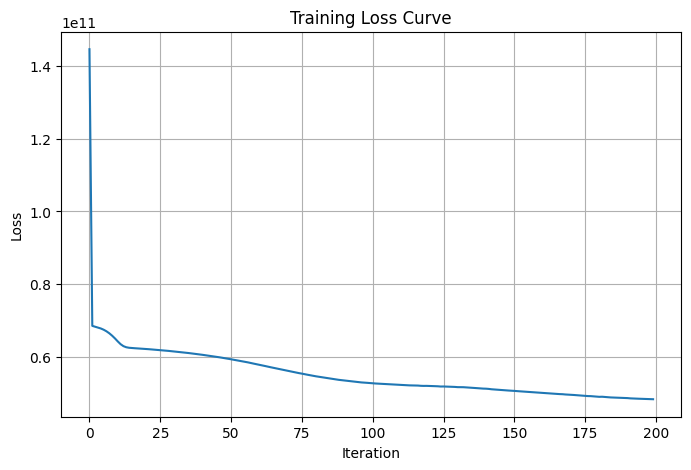

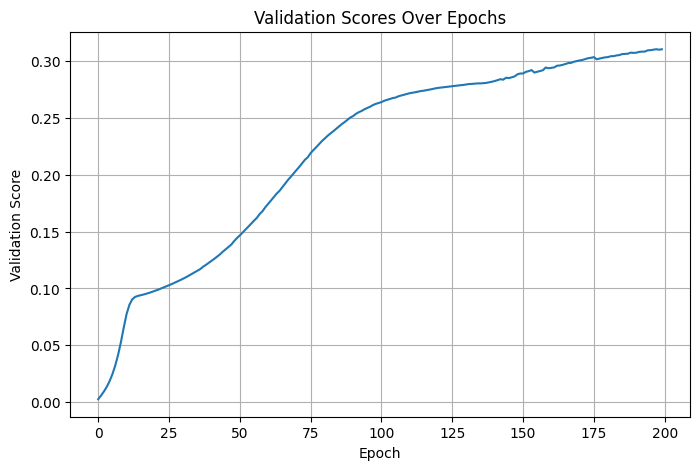

In [100]:
# ---- LOSS CURVE ----
plt.figure(figsize=(8, 5))
plt.plot(model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---- VALIDATION SCORES ----
plt.figure(figsize=(8, 5))
plt.plot(model.validation_scores_)
plt.title("Validation Scores Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Score")
plt.grid(True)
plt.show()

In [101]:
y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Score:", r2)
print("MAE:", mae)
print("MSE:", mse)

R² Score: 0.31603231376201646
MAE: 173616.92337461072
MSE: 90034305494.13628


In [102]:
# Could be better, but not bad for a first try
results = pd.DataFrame(data={"y_test": y_test, "y_pred": y_pred}).sort_values(by="y_test")
results

,y_test,y_pred
16165,75000.0,2.870169e+05
18149,81000.0,3.307453e+05
20914,84000.0,3.253639e+05
17093,85000.0,2.948198e+05
16347,89950.0,3.671857e+05
...,...,...
21501,3650000.0,1.049195e+06
20127,3650000.0,8.240380e+05
21310,4208000.0,8.923543e+05
19543,5300000.0,8.401308e+05


## SatCLIP + time embeddings

In [103]:
embedding_cols = [
    "satclip_embeddings",
    #"u10_hist_embeddings",
    #"v10_hist_embeddings",
    #"d2m_hist_embeddings",
    "t2m_hist_embeddings",
    #"msl_hist_embeddings",
    #"sp_hist_embeddings",
    "tp_hist_embeddings",
]

# 1. Expand all embedding columns into separate numeric columns
def expand_embedding_column(df, col):
    # convert list column into ndarray
    emb = np.stack(df[col].to_numpy())
    emb_df = pd.DataFrame(emb, index=df.index)
    emb_df.columns = [f"{col}_{i}" for i in emb_df.columns]
    return emb_df

expanded_parts = []

for col in embedding_cols:
    expanded_parts.append(expand_embedding_column(df, col))

# 2. Concatenate original non-embedding numeric columns + expanded embeddings
base_cols = [
    "dateOcurrence",
    "lat",
    "long",
    "nearest_grid_id",
    "nearest_grid_id_latitude",
    "nearest_grid_id_longitude",
]

X_numeric = df[base_cols].copy()

# Combine everything
X = pd.concat([X_numeric] + expanded_parts, axis=1)

# Or just use the embeddings
X = pd.concat(expanded_parts, axis=1)

# 3. Target column
y = df["price"]

# 4. Train/test split using your provided column
is_train = df["split"] == "Train"

X_train = X[is_train]
y_train = y[is_train]

X_test  = X[~is_train]
y_test  = y[~is_train]

X_train.shape, X_test.shape

((14633, 2304), (6980, 2304))

In [104]:
X_train.head()

satclip_embeddings_0  satclip_embeddings_1  satclip_embeddings_2  \
0              3.177715              5.105217              2.074342   
1              3.338348              5.317380              2.067900   
2              2.937354              4.762161              2.062209   
3              3.197419              5.130109              2.069079   
4              3.377787              5.364647              2.061774   

   satclip_embeddings_3  satclip_embeddings_4  satclip_embeddings_5  \
0             -0.778314             -2.385639             -0.178542   
1             -0.885236             -2.379581             -0.140310   
2             -0.624942             -2.369858             -0.265313   
3             -0.797897             -2.377681             -0.195006   
4             -0.918707             -2.372470             -0.151582   

   satclip_embeddings_6  satclip_embeddings_7  satclip_embeddings_8  \
0             -0.817988              2.967479              0.031168   
1             -0.792664              2.831061             -0.076021   
2             -0.822707              3.147778              0.205984   
3             -0.787119              2.961477              0.034619   
4             -0.757187              2.806548             -0.087294   

   satclip_embeddings_9  satclip_embeddings_10  satclip_embeddings_11  \
0              2.786367               2.736311               2.143397   
1              2.872022               2.738072               2.276907   
2              2.588128               2.713322               1.926639   
3              2.747158               2.742978               2.144015   
4              2.842960               2.744659               2.293431   

   satclip_embeddings_12  satclip_embeddings_13  satclip_embeddings_14  \
0              -1.720653               0.159583              -0.758859   
1              -1.774677               0.000829              -0.807200   
2              -1.649696               0.328173              -0.701481   
3              -1.744391               0.101776              -0.782867   
4              -1.803162              -0.076299              -0.837281   

   satclip_embeddings_15  satclip_embeddings_16  satclip_embeddings_17  \
0              -4.484253               0.773692              -2.569871   
1              -4.627157               0.728302              -2.797787   
2              -4.294348               0.825643              -2.239552   
3              -4.533101               0.759442              -2.604166   
4              -4.688472               0.706962              -2.860409   

   satclip_embeddings_18  satclip_embeddings_19  satclip_embeddings_20  \
0               2.153389               0.643925               0.437628   
1               2.080972               0.868740               0.155306   
2               2.252583               0.300070               0.827440   
3               2.155178               0.647651               0.405699   
4               2.072721               0.901981               0.086553   

   satclip_embeddings_21  satclip_embeddings_22  satclip_embeddings_23  \
0              -1.977680               0.659079               0.813386   
1              -1.980460               0.442081               0.905387   
2              -1.925554               0.976922               0.641934   
3              -1.955006               0.642678               0.789748   
4              -1.956045               0.398037               0.892980   

   satclip_embeddings_24  satclip_embeddings_25  satclip_embeddings_26  \
0              -0.033377              -0.572028              -1.988293   
1              -0.002009              -0.719353              -1.897392   
2              -0.111907              -0.349392              -2.099924   
3              -0.048616              -0.580739              -1.967444   
4              -0.011238              -0.748990              -1.862733   

   satclip_embeddings_27  satclip_embeddings_28  satclip_e

### Train

In [105]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [106]:
model = MLPRegressor(
    hidden_layer_sizes=(256,256),
    learning_rate_init=5e-3,
    max_iter=200,
    shuffle=False,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    batch_size=128
)
model.fit(X_train, y_train)

Iteration 1, loss = 143615610382.01589966
Validation score: -0.001699
Iteration 2, loss = 67429598820.24462891
Validation score: 0.004814
Iteration 3, loss = 67152403465.17192078
Validation score: 0.007604
Iteration 4, loss = 66918768207.86340332
Validation score: 0.010581
Iteration 5, loss = 66650709779.81822968
Validation score: 0.013939
Iteration 6, loss = 66336347737.05039215
Validation score: 0.017915
Iteration 7, loss = 65955812914.57698822
Validation score: 0.022799
Iteration 8, loss = 65483605919.74491119
Validation score: 0.029039
Iteration 9, loss = 64897276497.33424377
Validation score: 0.037513
Iteration 10, loss = 64180106013.27262878
Validation score: 0.049764
Iteration 11, loss = 63345830093.79755402
Validation score: 0.063500
Iteration 12, loss = 62461690320.16943359
Validation score: 0.075815
Iteration 13, loss = 61706900971.10070038
Validation score: 0.083310
Iteration 14, loss = 61229358130.94429779
Validation score: 0.087979
Iteration 15, loss = 60954334891.47840881

/home/mila/g/guzmand/scratch/.conda/envs/COMP-685/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(256, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,128
,learning_rate,'constant'
,learning_rate_init,0.005
,power_t,0.5
,max_iter,200
,shuffle,False


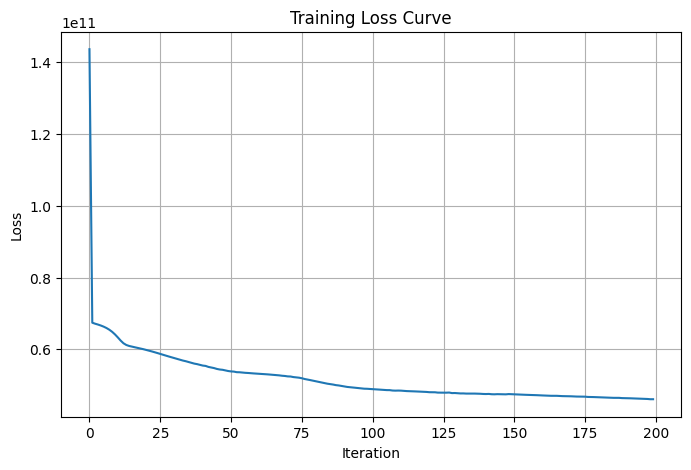

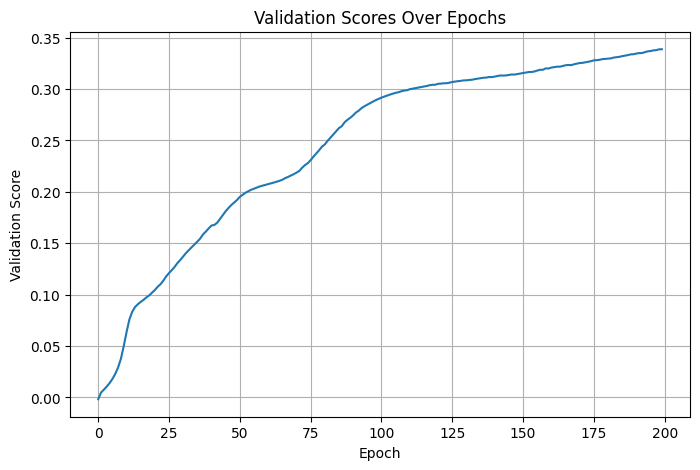

In [107]:
# ---- LOSS CURVE ----
plt.figure(figsize=(8, 5))
plt.plot(model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---- VALIDATION SCORES ----
plt.figure(figsize=(8, 5))
plt.plot(model.validation_scores_)
plt.title("Validation Scores Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Score")
plt.grid(True)
plt.show()

In [108]:
y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Score:", r2)
print("MAE:", mae)
print("MSE:", mse)

R² Score: 0.34049346503933264
MAE: 167958.75245391845
MSE: 86814354009.3612


In [110]:
# Could be better, but not bad for a first try
results = pd.DataFrame(data={"y_test": y_test, "y_pred": y_pred}).sort_values(by="y_test")
results

,y_test,y_pred
16165,75000.0,5.330999e+05
18149,81000.0,3.126136e+05
20914,84000.0,2.726914e+05
17093,85000.0,2.396065e+05
16347,89950.0,3.314159e+05
...,...,...
21501,3650000.0,1.042133e+06
20127,3650000.0,8.727338e+05
21310,4208000.0,9.566043e+05
19543,5300000.0,8.841226e+05
